<a href="https://colab.research.google.com/github/Gibbons-Lab/isb_course_2022/blob/main/micom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧫🦠 Modeling microbiota-wide metabolism with MICOM

This notebook will accompany the second session of the 2022 ISB Microbiome Course. The presentation slides can be [found here](https://gibbons-lab.github.io/isb_course_2022/micom). 

You can save your own local copy of this notebook by using `File > Save a copy in Drive`. You may be promted to cetify the notebook is safe. We promise that it is 🤞

**Disclaimer:**
The linear and quadratic programming problems MICOM has to solve are very large and very complicated. There are some very good commercial solvers that are very expensive (even though they are often free for academic use). To make this tutorial as accessible as possible we will use the Open Source solver [OSQP](https://osqp.org/), which is installed along with MICOM. OSQP is amazing with quadratic programming problems (kudos!) but not as accurate for linear problems. Solvers usually only guarantee a solution within a certain numerical tolerance of the real solution. In order to make everything work with OSQP this tolerance has to be relaxed to about 10<sup>-3</sup>. This means that any result with an absolute value smaller than that might very well be zero so we should look at larger values only. Installing cost-free academic versions of commercial solvers like [IBM CPLEX](https://www.ibm.com/analytics/cplex-optimizer) or [Gurobi](https://www.gurobi.com/) would alow you to lower the tolerance to 10<sup>-6</sup>.



# 📝 Setup

MICOM installation is is usually pretty straight-forward and can be as easy as typing `pip install micom` into your Terminal. 

First let's start by downloading the materials again and switching to the folder.

In [ ]:
!git clone https://github.com/gibbons-lab/isb_course_2022 materials
%cd materials

Cloning into 'materials'...
remote: Enumerating objects: 819, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 819 (delta 0), reused 2 (delta 0), pack-reused 811
Receiving objects: 100% (819/819), 246.65 MiB | 21.61 MiB/s, done.
Resolving deltas: 100% (302/302), done.
Checking out files: 100% (573/573), done.
/content/materials


## Basic Installation

Installing MICOM is straight-forward in Python. OSQP itself will be installed automatically along with it.

In [ ]:
!pip install -q micom

print("Done! 🎉 ")

     |████████████████████████████████| 832 kB 10.2 MB/s 
     |████████████████████████████████| 37.5 MB 60 kB/s 
     |████████████████████████████████| 2.4 MB 51.5 MB/s 
     |████████████████████████████████| 2.3 MB 62.2 MB/s 
     |████████████████████████████████| 44 kB 130 kB/s 
     |████████████████████████████████| 7.3 MB 49.0 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 147 kB 87.9 MB/s 
     |████████████████████████████████| 237 kB 89.1 MB/s 
     |████████████████████████████████| 109 kB 68.7 MB/s 
     |████████████████████████████████| 68 kB 6.6 MB/s 
     |████████████████████████████████| 80 kB 8.0 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 51 kB 6.8 MB/s 
     |████████████████████████████████| 546 kB 78.9 MB/s 
Done! 🎉 


## Enable QIIME 2 interactions

Before we start, we also need to install packages to read the "biom" file format used by QIIME 2 to save tables. This is only necessary if you want to read QIIME 2 FeatureTable artifacts (like the ones we constructed yesterday)

In [ ]:
!pip install -q numpy Cython
!pip install -q biom-format

print("Done! 🎉 ")

     |████████████████████████████████| 11.7 MB 13.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Done! 🎉 


Okay, all done. So let's get started building some models 🦺🛠d😁.

# 💻 MICOM

We will use the Python interface to MICOM since it plays nicely with Colaboratory. However, you could run the same steps within the QIIME 2 MICOM plugin ([q2-micom](https://library.qiime2.org/plugins/q2-micom/26/)). 

Here is an overview of all the steps and functions across both interfaces:
![micom overview](https://github.com/micom-dev/q2-micom/raw/706f583a060b91c12c0cec7acea2354fdd0dd320/docs/assets/overview.png)

The process of building a metabolic model in MICOM begins with constructing a combined abundance/taxonomy table, referred to hereafter as a taxonomy table. Let's load a sample taxonomy table to see what it looks like: 



In [ ]:
from micom.data import test_data

test_data().head()

,id,genus,species,reactions,metabolites,sample_id,abundance
0,Escherichia_coli_1,Escherichia,Escherichia coli 0,95,72,sample_1,576
1,Escherichia_coli_2,Escherichia,Escherichia coli 1,95,72,sample_1,671
2,Escherichia_coli_3,Escherichia,Escherichia coli 2,95,72,sample_1,698
3,Escherichia_coli_4,Escherichia,Escherichia coli 3,95,72,sample_1,197
0,Escherichia_coli_1,Escherichia,Escherichia coli 0,95,72,sample_2,106


In this taxonomy table, we see four identical strains of _E. coli_ (1 through 4), across two samples (sample_1 and sample_2). We can see that each row represents a single taxon in a single sample, and the `abundance` column identifies the abundance of that taxon in the sample. 

The `id` column specifies identifiers for the taxa and should be expressive and not include spaces or special characters. Since we are using a taxonomy database to build our models (more on that soon), we don't need a `file` column.

You might notice that this dataframe looks very different from what we generated in yesterday's tutorial, where we ended up with separate QIIME 2 artifacts 😱 

No worries, we can deal with that.

## Importing data from QIIME 2

MICOM can read QIIME 2 artifacts. You don't even need to have QIIME 2 installed for that! But before we do so, let's resolve one issue. We discussed that MICOM summarizes genome-scale models into pangenome-scale models as a first step, but our data are on the ASV level...so how will we know what to summarize?

Basically, a specific model database can be used to quickly summarize pangenome-scale models for use within MICOM. So, before we read our data we have to decide which model database to use. We will go with the [AGORA database](https://pubmed.ncbi.nlm.nih.gov/27893703/), which is a curated database of more than 800 bacterial strains that commonly live in the human gut. In particular, we will use a version of this database summarized on the genus rank which can be downloaded from the [MICOM data repository](https://doi.org/10.5281/zenodo.3755182), which contains a whole lot of prebuilt databases. This database is available from the materials folder that we previously cloned. 

Now we're all set to start building models! The data we previously collected can be found in the `treasure_chest` folder, so we can use those files to build our taxonomy for MICOM. 

In [ ]:
from micom.taxonomy import qiime_to_micom

tax = qiime_to_micom(
    "treasure_chest/dada2/table.qza", 
    "treasure_chest/taxa.qza", 
    collapse_on="genus"
)

Notice the `collapse_on` argument. That will specify the rank on which to sumarize and can be a list of several ranks. When matching taxonomy you can either match by the particular rank of interest (for example, just comparing genus names here), or you could compare the entire taxonomy, which will require all taxonomic ranks prior to the target rank to match. For that you cloud specify `collapse_on=["kingdom", "phylum", "class", "order", "family", "genus"]`. 

Taxonomic names will often not match 100% between databases. For instance, the genus name "Prevotella" in one database may be "Prevotella_6" in another. The more ranks you use for matching the more likely you are to run into these issues. However, the more taxonomic ranks you use to match the more confident you can be that your observed taxon really is the same taxon as the one in the model database.

The resulting table will contain the same abundances but it will include more ranks if `collapse_on` is a list. All ranks present in the taxonomy will be used when matching to the database. We will stick with the "lax" option of only matching on genus ranks.

Let's now take a look at the taxonomy table we generated:

In [ ]:
tax

,sample_id,abundance,genus,id,relative
0,chepang1,3697.0,Prevotella,Prevotella,0.483079
1,chepang2,2888.0,Prevotella,Prevotella,0.329982
2,chepang3,5779.0,Prevotella,Prevotella,0.693092
3,hadza1,188.0,Prevotella,Prevotella,0.012034
4,hadza2,4246.0,Prevotella,Prevotella,0.204439
...,...,...,...,...,...
464,mephaa1,3.0,Gabonia,Gabonia,0.000234
465,hadza2,2.0,Raoultibacter,Raoultibacter,0.000096
466,hadza3,2.0,Cetobacterium,Cetobacterium,0.000096
467,hadza3,2.0,Helicobacter,Helicobacter,0.000096


That looks more like the example! Again, we have a row for each taxon in each sample, so we're good to go. 

One helpful thing to do is to merge in our metadata, so we'll have it at hand for the following steps. In our case, the metadata will include the ethnic group, region, and subsistence type of each of the study participants. 

In [ ]:
import pandas as pd

metadata = pd.read_table("data/metadata.tsv").rename(columns={"id": "sample_id"})
tax = pd.merge(tax, metadata, on="sample_id")
tax

,sample_id,abundance,genus,id,relative,ethnic_group,subsistence,country,reference
0,chepang1,3697.0,Prevotella,Prevotella,0.483079,Chepang,slash and burn agriculture,Nepal,https://doi.org/10.1371%2Fjournal.pbio.2005396
1,chepang1,51.0,Faecalibacterium,Faecalibacterium,0.006664,Chepang,slash and burn agriculture,Nepal,https://doi.org/10.1371%2Fjournal.pbio.2005396
2,chepang1,2464.0,Succinivibrio,Succinivibrio,0.321965,Chepang,slash and burn agriculture,Nepal,https://doi.org/10.1371%2Fjournal.pbio.2005396
3,chepang1,27.0,Oscillibacter,Oscillibacter,0.003528,Chepang,slash and burn agriculture,Nepal,https://doi.org/10.1371%2Fjournal.pbio.2005396
4,chepang1,310.0,Prevotellamassilia,Prevotellamassilia,0.040507,Chepang,slash and burn agriculture,Nepal,https://doi.org/10.1371%2Fjournal.pbio.2005396
...,...,...,...,...,...,...,...,...,...
455,mephaa3,36.0,Fournierella,Fournierella,0.002661,Me’Phaa,slash and burn agriculture,Mexico,https://doi.org/10.3390%2Fmicroorganisms8101594
456,mephaa3,11.0,Colidextribacter,Colidextribacter,0.000813,Me’Phaa,slash and burn agriculture,Mexico,https://doi.org/10.3390%2Fmicroorganisms8101594
457,mephaa3,24.0,Weissella,Weissella,0.001774,Me’Phaa,slash and burn agriculture,Mexico,https://doi.org/10.3390%2Fmicroorganisms8101594
458,mephaa3,9.0,Lactococcus,Lactococcus,0.000665,Me’Phaa,slash and burn agriculture,Mexico,https://doi.org/10.3390%2Fmicroorganisms8101594


With our taxonmy table ready to go, and our metadata merged, its finally time to get to the model building! 🎉

## Building community models

With the data we have now, building our models is pretty easy. We just pass our taxonomy table and model database to MICOM. We will remove all taxa that make up less than 1% of the community to keep the models small and speed up this tutorial. We will also have to specify where to write the models. For simplicity, we'll run this process in parallel over two threads. It should take around 10 minutes to finish.

In [ ]:
from micom.workflows import build
from micom import Community
import pandas as pd

manifest = build(tax, "agora103_genus.qza", "models", solver="osqp", 
                 cutoff=0.01, threads=2)

Output()

You'll see a warning pop up indicating that less than 50% of the abundances can be matched to the database for one of the samples. This can happen with some data, and may indicate the models may not be completely representative of the samples.Typically a fraction of 80% or more is considered great. We'll continue, but remember to keep an eye out for this in future projects!

In lower-biomass 16S amplicon sequencing samples from stool, many reads can match to food components or to host mitochondria and these hits probably do not contribute much to bacterial community metabolism. These hits will be excluded from MICOM. 

Let's take a look what we got back from the `build` process.

In [ ]:
manifest

,sample_id,ethnic_group,subsistence,country,reference,file,found_taxa,total_taxa,found_fraction,found_abundance_fraction
0,chepang1,Chepang,slash and burn agriculture,Nepal,https://doi.org/10.1371%2Fjournal.pbio.2005396,chepang1.pickle,4.0,5.0,0.800000,0.841369
1,chepang2,Chepang,slash and burn agriculture,Nepal,https://doi.org/10.1371%2Fjournal.pbio.2005397,chepang2.pickle,4.0,8.0,0.500000,0.565356
2,chepang3,Chepang,slash and burn agriculture,Nepal,https://doi.org/10.1371%2Fjournal.pbio.2005398,chepang3.pickle,8.0,9.0,0.888889,0.916767
3,hadza1,Hadza,Hunter-gatherer,Tanzania,https://doi.org/10.1126/science.aan4834,hadza1.pickle,9.0,15.0,0.600000,0.530534
4,hadza2,Hadza,Hunter-gatherer,Tanzania,https://doi.org/10.1126/science.aan4835,hadza2.pickle,16.0,19.0,0.842105,0.854928
5,hadza3,Hadza,Hunter-gatherer,Tanzania,https://doi.org/10.1126/science.aan4836,hadza3.pickle,11.0,16.0,0.687500,0.458787
6,mephaa1,Me’Phaa,slash and burn agriculture,Mexico,https://doi.org/10.3390%2Fmicroorganisms8101592,mephaa1.pickle,11.0,18.0,0.611111,0.726720
7,mephaa2,Me’Phaa,slash and burn agriculture,Mexico,https://doi.org/10.3390%2Fmicroorganisms8101593,mephaa2.pickle,7.0,8.0,0.875000,0.795362
8,mephaa3,Me’Phaa,slash and burn agriculture,Mexico,https://doi.org/10.3390%2Fmicroorganisms8101594,mephaa3.pickle,7.0,8.0,0.875000,0.797945


This will tell you how many taxa were found in the database and what fraction of the total abundance was represented by the database. For most samples, this looks okay (i.e., >70% of abundance represented). 

So we now have our community models and can leverage MICOM fully by simulating community growth - let's discuss what we want to look at. 

### Comparative Metabolomics

Now that our models are ready to go, let's think about some of the insights we might gain from these samples. First and foremost, we can investigate the metabolomic response of the gut microbiome in a set of individuals from different underrepresented populations - in these different groups, do the microbes fall into different niche spaces?

Additionally, we can use MICOM to take a mechanistic look at how the microbiome of these individuals changes based on __dietary input__. That is, if we switch the diet of individuals from indigenous populations from a matched diet (i.e., a diet based on a typical meal eaten by an individual from that population) to an unmatched diet (e.g., the average Austrian diet), how does the metabolomic profile of the microbiome shift?

All that and more, coming up. Stay tuned!

First, we'll download the matched diets for each of our communities that we constructed by hand. Since this is a .csv file, we can read it using pandas.

In [ ]:
matched_medium = pd.read_csv('data/per_sample_media.csv')

You'll notice that this dataframe is pretty long - that's because this medium is "per-sample", meaning each of the nine models has it's own medium represented in the file, dependent on the traditional food of the community they live in. 

### Growing the models
Great, now we have our media & our models, it's time to get growing. We'll grow each of the nine samples using the per-sample matched medium. This will take some time, so we'll use that time as an opportunity to discuss more in depth what these processes do, and what to look for in the results. First, let's run the `grow()` command using the matched medium. This will take the models we've built, and find an optimal solution to the fluxes based upon the medium that's been applied.

If that takes too long or was aborted, we can read it in from the treasure chest.

In [ ]:
from micom.workflows import grow
import pickle

matched_growth = grow(manifest, "models", matched_medium, tradeoff=0.5, threads=2)

# We'll save the results to a file
pickle.dump(matched_growth, open("treasure_chest/matched_growth.pickle", "wb"))

Output()

/usr/local/lib/python3.7/dist-packages/micom/workflows/grow.py:199: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  exchanges["taxon"] = exchanges.index


Again, if that takes too long or was aborted, we can read it in from the treasure chest.

In [ ]:
# Will only run if the previous step failed

import pickle

try:
  matched_growth
except NameError:
  matched_growth = pickle.load(open("treasure_chest/matched_growth.pickle", "rb"))

What kind of results did we get? Well, `grow` returns a tuple of 3 data sets:

1. The predicted growth rate for all taxa in all samples
2. The import and export fluxes for each taxon and the external environment
3. Annotations for the fluxes mapping to other databases

### 📈 Growth Rates

The growth rates are pretty straightforward.

In [ ]:
matched_growth.growth_rates

,abundance,growth_rate,reactions,metabolites,taxon,tradeoff,sample_id
compartments,,,,,,,
Catenibacterium,0.025004,0.162352,1660,1266,Catenibacterium,0.5,chepang1
Phascolarctobacterium,0.018171,0.075259,1019,945,Phascolarctobacterium,0.5,chepang1
Prevotella,0.574157,3.829634,2861,1722,Prevotella,0.5,chepang1
Succinivibrio,0.382668,2.551436,1130,1051,Succinivibrio,0.5,chepang1
Faecalibacterium,0.021625,0.168549,1986,1472,Faecalibacterium,0.5,chepang2
...,...,...,...,...,...,...,...
Faecalibacterium,0.115217,1.193875,1986,1472,Faecalibacterium,0.5,mephaa3
Prevotella,0.767806,7.965889,2861,1722,Prevotella,0.5,mephaa3
Roseburia,0.018802,0.194125,2357,1567,Roseburia,0.5,mephaa3


### ↔️ Exchange Fluxes 

More interesting are the exchange fluxes. These reactions represent the import and export of metabolites from the system Let's look at those now:

In [1]:
matched_growth.exchanges

NameError: ignored

So we see how much of each metabolite is either consumed or produced by each taxon in each sample. `tolerance` denotes the accuracy of the solver and tells you the smallest absolute flux that is likely different form zero (i.e., substantial flux). *All of the fluxes are normalized to 1g dry weight of bacteria*. So, you can directly compare fluxes between taxa, even if they are present at very different abundances. 

If you're curious what the abbreviation for each of these metabolites represents, that can be found in the annotations dataframe. For instance, let's find out what `"but[e]"` represents. 

In [ ]:
anns = unmatched_growth.annotations
anns[anns.metabolite == "but[e]"]

,metabolite,name,molecular_weight,C_number,N_number,hmdb,inchi,kegg.compound,pubchem.compound,reaction
reaction,,,,,,,,,,
EX_but(e),but[e],butyrate,87.09718,4,0,HMDB00039,"InChI=1S/C4H8O2/c1-2-3-4(5)6/h2-3H2,1H3,(H,5,6...",C00246,264,EX_but(e)


Butyrate! Interesting, [that's an important metabolite](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8608412/)! All of these annotations and more information at are also available at https://vmh.life, maintained by Dr. Ines Thiele's lab. 

We want to compare these results from our matched medium against an unmatched medium, to illustrate how important it is to use the proper dietary inputs for the modeling process. Rather than repeat all the steps above, we can load in the results from the treasure chest. The following cell will load the growth results for the same models as above, but with an unmatched medium applied. In this case, the unmatched medium is an average Austrian diet. 

In [ ]:
try:
  unmatched_growth
except NameError:
  unmatched_growth = pickle.load(open("treasure_chest/unmatched_growth.pickle", "rb"))


# 📊 Visualizations

Let's visualize our results. Because of the rich output of these models, it can be overwhelming to represent it all, but don't worry! There are tools in place for this already. 

We will use the standard visualizations included in MICOM. These tools take in the growth results we obtained before and create visualizations in standalone HTML files that bundle the plots and raw data and can be viewed directly in your browser.

First, let's look at the growth rates of each taxon across samples. 

In [ ]:
from micom.viz import *

viz_unmatched = plot_growth(unmatched_growth, filename="unmatched_growthrates.html")
viz_matched = plot_growth(matched_growth, filename="matched_growthrates.html")

Normally, we could call `viz.view()` afterwards and it would open it in our web browser. However, this will not work in Colab. However, the plot function creates the file `growth_rates_[DATE].html` in your `materials` folder. To open it, simply download that file and view it in your web browser. We can see that there are many things going on, but it's not super clear. Let's continue.

## Growth niches

Another thing we can look at is whether individual taxa inhabit different growth niches across different dietary contexts. Here we can use the `plot_exchanges_per_taxon` function to see how exchanges differ within and between taxa, within and across human populations. 

In [ ]:
plot_exchanges_per_taxon(unmatched_growth, perplexity=4, direction="import", filename="unmatched_niche.html")
plot_exchanges_per_taxon(matched_growth, perplexity=4, direction="import", filename="matched_niche.html")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,



This function projects the full set of import or export fluxes onto a two dimensional plane, and arranges taxa so that more similar flux patterns lie nearer together. Taxa closer to one another compete for a more similar set of resources (and/or produce a more similar set of metabolites). The center of the plot signifies a more competitive nutrient space, whereas clusters on the outskirts denote more isolated niches.

You can tune [TSNE parameters](https://distill.pub/2016/misread-tsne/), such as perplexity, to get a more meaningful grouping. We will lower the perplexity here since we don't have a lot of data points.


## Comparative Metabolomics

Now let's compare the metabolomic exports between the two dietary contexts. We're interested to see how the metabolomic profile of the microbiome changes when the diet changes, as changes in diet can lead to changes in host health.  To look into this deeper, we'll concatenate the exchange results into one dataframe, transform the data and then plot the metabolite exports on a heatmap. 

First let's annotate each dataframe with its medium:

In [ ]:
unmatched_growth.exchanges['diet'] = 'unmatched'
matched_growth.exchanges['diet'] = 'matched'

Now we'll concatenate the dataframes. MICOM fluxes are returned as normalized values, so we'll have to multiply the exchange flux by the corresponding taxonomic abundance. We'll also run a centered log ratio transformation on the data, to account for the compositional nature of these data and compare all the fluxes against each other. 

In [ ]:
import pandas as pd
import numpy as np

exports = pd.concat([unmatched_growth.exchanges, matched_growth.exchanges])
exports = exports[exports.direction == "export"].groupby(["diet","sample_id", "metabolite", "reaction"]).apply(
    lambda df: sum(df.flux * df.abundance)).reset_index().rename(columns = {0:'flux'}) #multiply flux by abundance
exports = pd.pivot_table(exports, index = ['diet','sample_id'], columns = 'metabolite', values = 'flux')
exports = exports.T.fillna(0.0)
exports = exports.apply(
    lambda xs: np.log(xs + 0.001) - np.log(xs.mean() + 0.001),
    axis=1)
exports = exports.reindex(exports.sum(axis = 1).sort_values().index)

We can use seaborn to plot our heatmap:

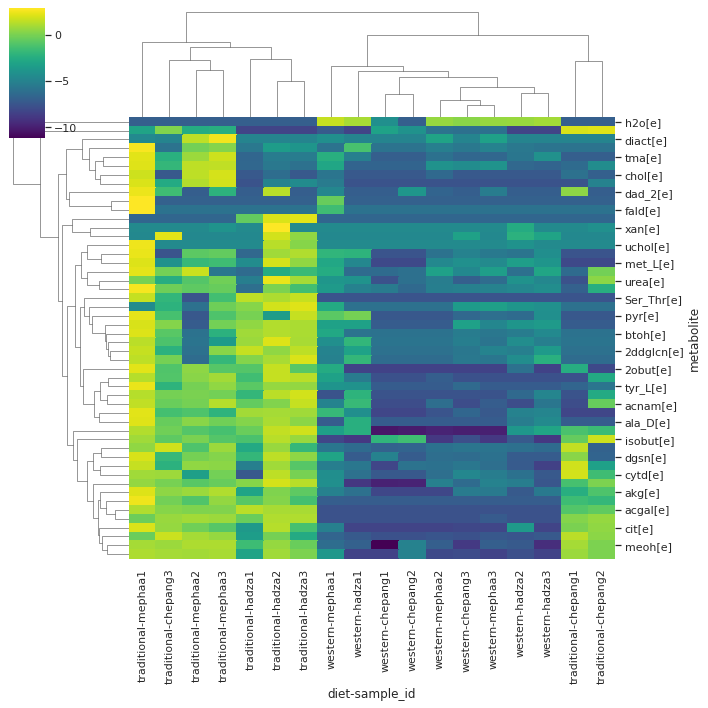

In [ ]:
import seaborn as sns 
import numpy as np

sns.set(rc = {'figure.figsize':(15,30)})
sns.clustermap(exports.head(50), cmap = 'viridis')

# 🏫 Exercises

Up to now, we have mostly used MICOM's "high-level" API, which is designed for working with several samples in parallel. However, MICOM also allows you to work with single models. We will choose a single sample now for further analysis.

First, let's recall what samples we had: 

In [ ]:
manifest

,sample_id,ethnic_group,subsistence,country,reference,file,found_taxa,total_taxa,found_fraction,found_abundance_fraction
0,chepang1,Chepang,slash and burn agriculture,Nepal,https://doi.org/10.1371%2Fjournal.pbio.2005396,chepang1.pickle,4.0,5.0,0.800000,0.841369
1,chepang2,Chepang,slash and burn agriculture,Nepal,https://doi.org/10.1371%2Fjournal.pbio.2005397,chepang2.pickle,4.0,8.0,0.500000,0.565356
2,chepang3,Chepang,slash and burn agriculture,Nepal,https://doi.org/10.1371%2Fjournal.pbio.2005398,chepang3.pickle,7.0,9.0,0.777778,0.828136
3,hadza1,Hadza,Hunter-gatherer,Tanzania,https://doi.org/10.1126/science.aan4834,hadza1.pickle,7.0,15.0,0.466667,0.496223
4,hadza2,Hadza,Hunter-gatherer,Tanzania,https://doi.org/10.1126/science.aan4835,hadza2.pickle,14.0,19.0,0.736842,0.773316
5,hadza3,Hadza,Hunter-gatherer,Tanzania,https://doi.org/10.1126/science.aan4836,hadza3.pickle,9.0,16.0,0.562500,0.424079
6,mephaa1,Me’Phaa,slash and burn agriculture,Mexico,https://doi.org/10.3390%2Fmicroorganisms8101592,mephaa1.pickle,10.0,18.0,0.555556,0.707239
7,mephaa2,Me’Phaa,slash and burn agriculture,Mexico,https://doi.org/10.3390%2Fmicroorganisms8101593,mephaa2.pickle,7.0,8.0,0.875000,0.795362
8,mephaa3,Me’Phaa,slash and burn agriculture,Mexico,https://doi.org/10.3390%2Fmicroorganisms8101594,mephaa3.pickle,7.0,8.0,0.875000,0.797945


## Diet-Specific Interactions
We can use the `load_pickle` funciton in MICOM to load one of the models we're interested in, and look at differences in growth between the two diets we have available. 

In [ ]:
from micom import load_pickle
from micom.qiime_formats import load_qiime_medium

matched_medium = pd.read_csv("data/per_sample_media.csv")
matched_medium = matched_medium[matched_medium['sample_id'].str.contains('chepang1')]
matched_medium.index = matched_medium.reaction

com = load_pickle("models/chepang1.pickle")
com.medium = matched_medium.flux
sol = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
sol

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Catenibacterium,0.025004,0.162238,1660,1266
Phascolarctobacterium,0.018171,0.076950,1019,945
Prevotella,0.574157,3.829102,2861,1722
Succinivibrio,0.382668,2.548651,1130,1051
medium,NaN,NaN,621,621


Go ahead and try growing this model using the other available medium (i.e., the average Austrian diet):

In [ ]:
# Your code here

In [ ]:
# Your code here

# 🔵 Addendum


## Choosing a tradeoff value

Even if you don't have growth rates available you can still use your data to choose a decent tradeoff value. This can be done by choosing the largest tradeoff value that still allows growth for the majority of the taxa that you observed in the sample (if they are present at an appreciable abundance, they should be able to grow). This can be done with the `tradeoff` workflow in MICOM that will run cooperative tradeoff with varying tradeoff values, which can be visualized with the `plot_tradeoff` function.

In [ ]:
from micom.workflows import tradeoff
import micom

tradeoff_results = tradeoff(manifest, "models", matched_medium, threads=2)
tradeoff_results.to_csv("tradeoff.csv", index=False)

plot_tradeoff(tradeoff_results, tolerance=1e-4)

After opeing `tradeoff_[DATE].html` you will see that, for our example here, all tradeoff values work great. This is because we modeled very few taxa, which keeps the compettion down. If you would allow for fewer abundant taxa in the models, this would change drastically. For instance, here is an example from a colorectal cancer data set:

[![tradeoff example](https://micom-dev.github.io/micom/_images/tradeoff.png)](https://micom-dev.github.io/micom/_static/tradeoff.html)

You can see how not using the cooperative tradeoff would give you nonsense results where only 10% of all observed taxa grew. A tradeoff value of 0.6-0.8 would probably be a good choice for this particular data set.